In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0)

In [2]:
# Prior array represents the prior probability
prior_arr = np.append(np.repeat(False, 990), np.repeat(True, 10))

# Likelihood array represents both TPR and FPR
likelihood_arr = np.append(np.repeat(True, 95), np.repeat(False, 5))

Simulate a population size of 1000. Iterate through each person — let’s use i as the index —
and use np.random.choice() to sample from the prior array. Obviously you will get
99% False (without disease) and 1% True (with disease). Check to make sure that is
indeed the case: you can sample 1000 times and count the results (in code, obviously).

In [3]:
pop_1000 = np.random.choice(prior_arr, size=(1000,))

In [4]:
# Function to count zero and non-zeros
def count_sample(sample: np.ndarray) -> tuple[int, int]:
    """
    Count the number of zero and non-zero in an array
    
    Args:
        sample: ndarray
        
    Returns:
        tuple of (zero_count, non_zero_count)
    """
    
    sample_flat = sample.flatten()
    m = sample_flat.shape[0]
    nonzero = np.count_nonzero(sample_flat)
    return m - nonzero, nonzero

In [5]:
false_count, true_count = count_sample(pop_1000)
print(f"False: {false_count}, True: {true_count}")

False: 992, True: 8


In [6]:
def simulate_pop(prior, likelihood, likelihood_alt=None, count=1000) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate a sample population (with ground truth label and predicted label) 
    
    Args:
        prior: the prior to draw population from
        likelihood: likelihood of testing positive, given the person has the disease
        likelihood_alt: likelihood of testing negative, given the person doesn't have the disease
        count: sample count
        
    Returns:
        tuple of (samples, test_results)
    """
    
    samples = np.array([], dtype=bool)
    test_results = np.array([], dtype=bool)

    # Assume likelihood_alt = ~likelihood
    if likelihood_alt is None:
        likelihood_alt = np.logical_not(likelihood)
    
    for i in range(count):
        sample = np.random.choice(prior)
        if sample:
            result = np.random.choice(likelihood)
        else:
            result = np.random.choice(likelihood_alt)
            
        samples = np.append(samples, sample)
        test_results = np.append(test_results, result)
        
    return samples, test_results

In [7]:
samples, test_results = simulate_pop(prior_arr, likelihood_arr)

In [8]:
no_disease, yes_disease = count_sample(samples)
print(f"Not infected={no_disease}, Infected={yes_disease}")

test_correct, test_incorrect = count_sample(test_results)
print(f"Test correct={test_correct}, Test incorrect={test_incorrect}")

Not infected=988, Infected=12
Test correct=945, Test incorrect=55


In [9]:
# If prior_sample[i] & test_result[i] -> TP
# If !prior_sample[i] & test_result[i] -> FP

def count_tp_fp(ground_truth: np.ndarray, pred: np.ndarray) -> tuple[int, int]:
    """
    Count the true_positive and false_positive, given ground truth and predicted label
    
    Args:
        ground_truth: the ground truth label
        pred: predicted label
        
    Returns:
        tuple of (true positive, false positive)
    """
    
    assert ground_truth.shape == pred.shape, "Dimensions of inputs don't match"
    tp = 0
    fp = 0
    m = ground_truth.shape[0]
    for i in range(m):
        if ground_truth[i] == True and pred[i] == True:
            tp += 1
        elif ground_truth[i] == False and pred[i] == True:
            fp += 1
    return tp, fp

In [10]:
tp, fp = count_tp_fp(samples, test_results)
print(f"True positive={tp}, False positive={fp}")

True positive=12, False positive=43


In [11]:
new_prior = tp / (tp + fp)
print(f"new_prior={new_prior}")

new_prior=0.21818181818181817


In [12]:
def repeat_sampling(k, prior, likelihood, likelihood_alt=None, sample_count=1000):
    priors = np.array([])

    for i in range(k):
        samples, test_results = simulate_pop(prior, likelihood, likelihood_alt, sample_count)
        tp, fp = count_tp_fp(samples, test_results)
        new_prior = tp / (tp + fp)
        priors = np.append(priors, new_prior)
        
    return priors

In [13]:
priors = repeat_sampling(3, prior_arr, likelihood_arr, sample_count=1000)
priors

array([0.20588235, 0.16176471, 0.12      ])

In [14]:
def priors_stat(priors: np.ndarray):
    mean = np.mean(priors)
    median = np.median(priors)
    unique_vals, counts = np.unique(priors, return_counts=True)
    mode = unique_vals[np.argmax(counts)]
    std = np.std(priors)

    return {
        'mean': mean,
        'median': median,
        'mode': mode,
        'std': std
    }

In [15]:
stat = priors_stat(priors)
print(stat)

{'mean': np.float64(0.16254901960784315), 'median': np.float64(0.16176470588235295), 'mode': np.float64(0.12), 'std': np.float64(0.035065709724203926)}


Plotting Histogram

In [16]:
def plot_hist(data: np.ndarray, n_bins: int, vline_val:float, debug:bool=False):
    """Plot the histogram"""

    counts, bin_range = np.histogram(data, bins=n_bins)
    
    if debug:
        print("Histogram counts:", counts)
        print("Bin range:", bin_range)
        
    plt.hist(bin_range[:-1], bin_range, weights=counts)
    plt.vlines(vline_val, ymin=0, ymax=np.max(counts), colors='green', label='expected')
    plt.show()

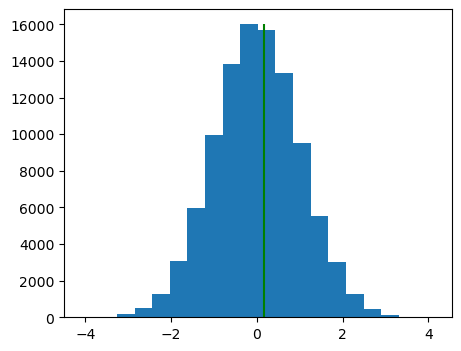

In [17]:
data = np.random.randn(100000)
plot_hist(data, n_bins=20, vline_val=0.16)

Histogram counts: [1 1 1]
Bin range: [0.12       0.14862745 0.1772549  0.20588235]


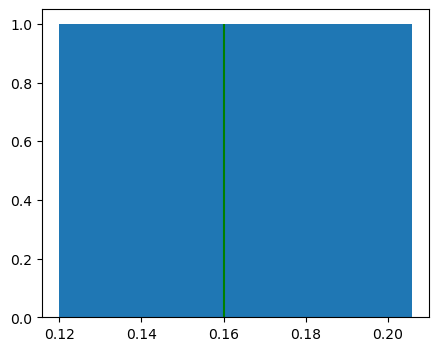

In [18]:
plot_hist(priors, n_bins=3, vline_val=0.16, debug=True)

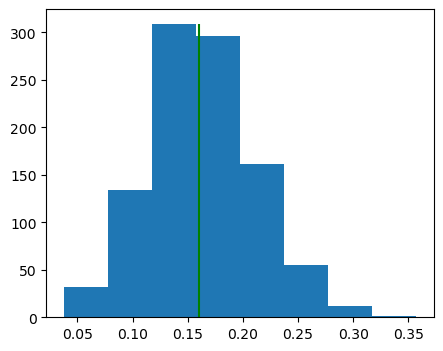

In [19]:
priors = repeat_sampling(1000, prior_arr, likelihood_arr, sample_count=1000)
plot_hist(priors, n_bins=8, vline_val=0.16)

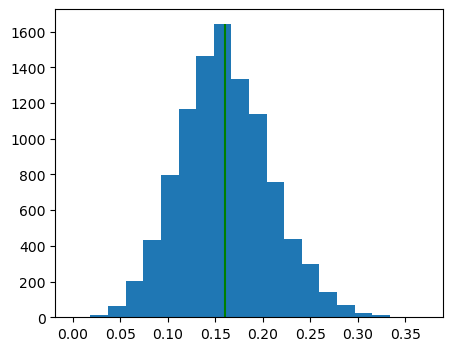

In [20]:
priors = repeat_sampling(10000, prior_arr, likelihood_arr, sample_count=1000)
plot_hist(priors, n_bins=20, vline_val=0.16)